In [1]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5
import scipy
import matplotlib.patches as patches
import pandas as pd
from scipy.io import readsav
from regions import Regions #read_ds9, write_ds9
import csv
import math
from scipy.optimize import curve_fit
import time
from pathlib import Path
from pyds9 import ds9
from scipy.integrate import quad
from astropy.table import QTable, Table, Column, vstack

/Users/Prabhani/opt/anaconda3/lib/python3.9/site-packages/pyds9.py:94: UserWarning: Can't locate the X11 DS9 executable in your PATH or the Aqua SAOImage DS9 app in /Applications, $HOME or $HOME/Applications. Please configure your PATH or make SAOImage DS9 available in a known location.
  warnings.warn(ds9_warning)


In [3]:
hdr = fits.getheader('ISF_Mosaic_Trial5_drz_sci.fits')
im  = fits.getdata('ISF_Mosaic_Trial5_drz_sci.fits')
wcs = WCS(hdr)

In [4]:
def write_regf(ra, dec, fname, c, text, r=None, update=False):
    """
    fname - file name to be written
    c - region color
    """
    xx, yy = ra, dec
    text = np.array(text, dtype=str)
    if r==None:
        r =25
    else:
        r=r
    if update == True:
        with open(fname) as unt:
            lines = unt.readlines()
        with open(fname, 'w') as unt:    
            unt.writelines(lines)

            for i in range(len(xx)):
                unt.write('\n')
                if text.size == 0:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+'')
                else:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+
                              ' text={'+str(text[i])+'}')
    else:
        with open(fname, 'w') as unt:
            unt.write('fk5')
            for i in range(len(xx)):
                unt.write('\n')
                if text.size == 0:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+'')
                else:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+
                              ' text={'+str(text[i])+'}')

In [5]:
def norm_logistic_reg(x, mu, sig):
    w = 1/(1+np.exp(-((x-mu)/sig)))
    return w

In [6]:
def r_times_logistic_reg(x, m, s):
    w = x/(1+np.exp(-((x-m)/s)))
    return w

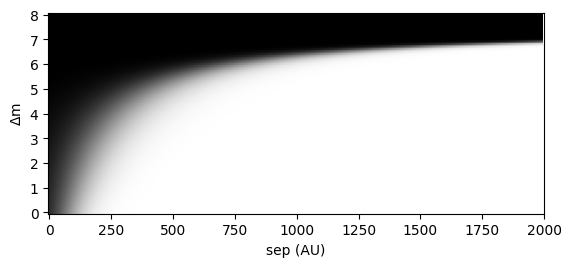

In [7]:
frac_mtx = np.loadtxt('Fraction_dm_sep_array.txt')
fig, ax = plt.subplots()
plt.imshow(frac_mtx, origin='lower', cmap='gray')
locs = plt.xticks()
plt.xticks(locs[0][1::], np.arange(0, 2001, 250))
locs = plt.yticks()
plt.yticks(locs[0][1:-1], np.arange(0, 9, 1))
plt.xlabel('sep (AU)')
plt.ylabel('$\Delta$m');

In [8]:
df_params = pd.read_csv('mu_sig_params.csv')
mu, sig = np.array(df_params['mu']), np.array(df_params['sig'])
df_flame = pd.read_csv('dm_sep_flame.csv')
sep_flame, dm_flame = np.array(df_flame['sep']), np.array(df_flame['dm'])

In [10]:
df_final = pd.read_csv('dash_rereduce_removed_combined_with_rereduceII_with_VISION.csv')
df_final2 = df_final
ra_f2 = np.array(df_final2['RA_d'])
dec_f2 = np.array(df_final2['DEC_d'])
m_f2 = np.array(df_final2['MAG_d'])
me_f2 = np.array(df_final2['MAG_d_unc'])
h_f2 = np.array(df_final2['H_v'])
he_f2 = np.array(df_final2['He_v'])
k_f2 = np.array(df_final2['Ks_v'])
ke_f2 = np.array(df_final2['Kse_v'])
fwhm_f2 = np.array(df_final2['FWHM_d'])
rsat_f2 = np.array(df_final2['R_SAT_d'])
clas_f2 = np.array(df_final2['class'], dtype=str)

yso_clas = np.array(['protostars', 'disks', 'td', 'nd_proto_faint'])
i_yso, = np.where(np.isin(clas_f2, yso_clas))

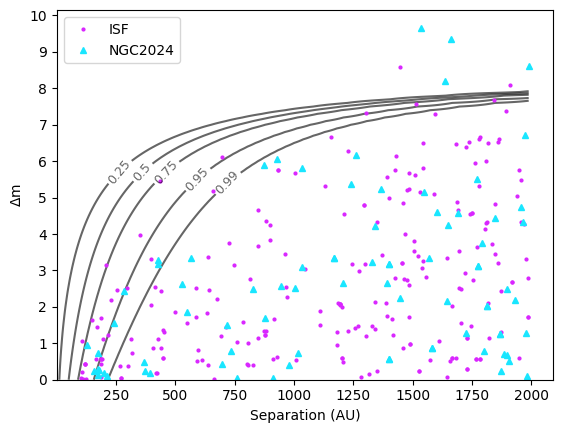

In [11]:
dms = np.arange(0, 8.01, 1/10)
seps = np.arange(50, 2050., 100/10)
dm_mtx, sep_mtx = np.indices((len(dms), len(seps)))
#sep_mtx = np.tile(np.arange(0, 2000.1, 0.1), )
dm_mtx, sep_mtx = (np.flip(dm_mtx,0))/10, 100*(sep_mtx+5)/10
frac_mtx = np.zeros(dm_mtx.shape)
n_dm = len(dms)
for i in range(len(mu)):
    frac_mtx[i, :] =  norm_logistic_reg(seps, mu[i], sig[i])

cmap = plt.cm.cool
category_colors = plt.colormaps['cool'](
        np.linspace(0.10, 0.85, 6))

fig, ax = plt.subplots()
#plt.imshow(frac_mtx, origin='lower', cmap='Greys_r', aspect="auto")
#colors=[category_colors[0]]

c25 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.25], colors='k', alpha=0.6)
c50 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.50], colors='k', alpha=0.6)
c75 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.75], colors='k', alpha=0.6)
c95 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.95], colors='k', alpha=0.6)
c99 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.99], colors='k', alpha=0.6)

xt = ax.get_xticks()
ax.set_xticks(xt[1::], np.round(xt[1::]*100/10).astype(int))
yt = ax.get_yticks()
ax.set_yticks(yt[1:-1], np.round((yt[1:-1])/10).astype(int))

manual_locations = [(20, 60)]
plt.clabel(c25, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(30, 60)]
plt.clabel(c50, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(40, 60)]
plt.clabel(c75, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(50, 60)]
plt.clabel(c95, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(60, 60)]
plt.clabel(c99, fontsize=9, inline=1, manual=manual_locations)

ax.set_xlabel('Separation (AU)')
ax.set_ylabel('$\Delta$m')


ra_cat, dec_cat, m_cat, i_yso = ra_f2, dec_f2, m_f2, i_yso
N_total = len(i_yso)
N_cand, N_cont = 0, 0
r1_comp = 100
r2_comp = 2000
r1_cont = 2000
r2_cont = 5000

#Making a catalog object using all sources
c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
              distance=390.*u.pc, frame='fk5')

ra_yso  = ra_cat[i_yso]
dec_yso = dec_cat[i_yso]
m_yso   = m_cat[i_yso]

i_tested = np.array([])
N_cand   = np.array([])

d_comp = np.array([])
dm_comp = np.array([])

for i in range(N_total):
    #Making a catalog object using YSO
    c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=400.*u.pc, frame='fk5')
    sep_     = c2.separation(c1).arcsec*400.
    i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp)&(m_cat>10.5))
    n_obj    = len(i_obj_)

    if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.):
        ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
        dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
        m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array

        i_prim, = np.where(m_sys==np.min(m_sys))
        i_comp, = np.where(m_sys!=np.min(m_sys))
        N_cand  = N_cand + len(i_comp)
        ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
        ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]
        m_prim = m_sys[i_prim]
        c_comp = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=400.*u.pc, frame='fk5')

        c_prim = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=400.*u.pc, frame='fk5')
        sep_comp = c_comp.separation(c_prim).arcsec*400.
        #ax.plot(sep_comp, m_sys[i_comp]-m_prim, '.r')
        d_comp = np.append(d_comp, sep_comp)
        dm_comp = np.append(dm_comp, np.abs((m_sys[i_comp]-m_prim)))
ax.plot(d_comp/10, dm_comp*10, '.', c=category_colors[5], ms=4, label='ISF')
ax.plot(sep_flame/10, dm_flame*10, '^', c=category_colors[0], ms=4, label='NGC2024')
#ax.set_ylim(0, 100)
#ax.set_yticks(np.arange(0, 11, 1))
#yticks = ax.get_yticks()

ax.set_yticks(np.arange(0, 110, 10), np.arange(0, 11, 1));
ax.legend()

In [12]:
def CF(ra_cat, dec_cat, m_cat, i_yso):
#ra_cat, dec_cat, m_cat, i_yso = ra_Dcat, dec_Dcat, m_Dcat, i_Dyso
    N_total = len(i_yso)
    N_cand, N_cont, N_comp = 0, 0, 0
    
    r1_comp = 100
    r2_comp = 1000
    r1_cont = 2000
    r2_cont = 5000
    
    def r_times_logistic_reg(x, m, s):
        w = x*1/(1+np.exp(-((x-m)/s)))
        return w
    
    
    #Making a catalog object using all sources
    c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
                  distance=390.*u.pc, frame='fk5')
   
    ra_yso  = ra_cat[i_yso]
    dec_yso = dec_cat[i_yso]
    m_yso   = m_cat[i_yso]
    
    i_tested = np.array([])

    R = np.array([])
    R_unc = np.array([])
    N_cont_init = np.array([])
    N_cont_corr = np.array([])
    N_cont_prior_corr = np.array([])
    d_mag = np.array([])
    dist = np.array([])
    fig, ax = plt.subplots()
    for i in range(N_total):
        #Making a catalog object using YSO
        c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=400.*u.pc, frame='fk5')
        sep_     = c2.separation(c1).arcsec*400.
        i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp)&(m_cat>10.5))
        n_obj    = len(i_obj_)
        
        if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.):
            ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
            dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
            m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array
            
            i_prim, = np.where(m_sys==np.min(m_sys))
            i_comp, = np.where(m_sys!=np.min(m_sys))
            N_cand  = N_cand + len(i_comp)
            ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
            ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]
            m_prim = m_sys[i_prim]
            c_comp = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=400.*u.pc, frame='fk5')
        
            c_prim = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=400.*u.pc, frame='fk5')
            sep_comp = c_comp.separation(c_prim).arcsec*400.
            #ax.plot(sep_comp, m_sys[i_comp]-m_prim, '.r')
            
            #making a new cat obj with the dimmest objects in the system
            c3       = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, 
                                distance=400.*u.pc, frame='fk5')
            sep      = c2.separation(c3).arcsec*400.
            
            i_cont,  = np.where((sep>=r1_cont)&(sep<=r2_cont))
            N_cont_init = np.append(N_cont_init, len(i_cont))
            n_cont = 0
            for j in range(len(i_cont)):
                delta_m = m_cat[i_cont[j]]-m_prim
                dm_ind  = int(np.abs(10*np.round(delta_m, 1)))
                if dm_ind>80:
                    mu_, sig_ = 0, 0
                    R_ = 0
                else:
                    mu_  = mu[dm_ind]
                    sig_ = sig[dm_ind]
                    I  = quad(r_times_logistic_reg, 100, 1000, args=(mu_, sig_))
                    R_ = 2*np.pi * I[0] / (np.pi*(5000**2 - 2000**2))
                    R  = np.append(R, R_)
                    d_mag=np.append(d_mag,dm_ind)
                    R_unc   = np.append(R_unc, I[1])
                    dist = np.append(dist, sep[i_cont[j]])
                n_cont  = n_cont + R_
                #if n_cont > 0.5:
                #    ax.plot(sep_comp, m_sys[i_comp]-m_prim, '.r')
            N_cont_corr = np.append(N_cont_corr, n_cont)
            N_cont_prior_corr = np.append(N_cont_prior_corr, 
                                          len(i_cont)*(1000**2-100**2)/(5000**2-2000**2))
            #if i==0:
            #    print(N_comp.shape)
            N_comp = N_comp + (len(i_comp) - n_cont)
            
    category_colors = plt.colormaps['plasma'](np.linspace(0.05, 0.85, 5))
    for i in range(len(dist)):
        ax.plot(dist[i], d_mag[i], '.', color=category_colors[int(100*np.round(R[i], 3))])           
    print('N_cand: ', N_cand)
    print('N_cont within 200-5000 (before correction): ', np.sum(N_cont_prior_corr))
    print('N_cont within 200-5000: ', np.sum(N_cont_corr))
    print('N_comp: ', N_comp)
    print('CF ('+str(N_total)+'): ', N_comp/N_total)
    return d_mag, R, dist

In [117]:
def CF(ra_cat, dec_cat, m_cat, i_yso):
#ra_cat, dec_cat, m_cat, i_yso = ra_Dcat, dec_Dcat, m_Dcat, i_Dyso
    N_total = len(i_yso)
    N_cand, N_cont, N_comp = 0, 0, 0
    
    r1_comp = 100
    r2_comp = 1000
    r1_cont = 2000
    r2_cont = 5000
    
    def r_times_logistic_reg(x, m, s):
        w = x*1/(1+np.exp(-((x-m)/s)))
        return w
    
    
    #Making a catalog object using all sources
    c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
                  distance=390.*u.pc, frame='fk5')
   
    ra_yso  = ra_cat[i_yso]
    dec_yso = dec_cat[i_yso]
    m_yso   = m_cat[i_yso]
    
    i_tested = np.array([])

    R = np.array([])
    R_unc = np.array([])
    N_cont_init = np.array([])
    N_cont_corr = np.array([])
    N_cont_prior_corr = np.array([])
    N_cont = 0
    d_mag = np.array([])
    dist = np.array([])
    fig, ax = plt.subplots()
    for i in range(N_total):
        #Making a catalog object using YSO
        c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=400.*u.pc, frame='fk5')
        sep_     = c2.separation(c1).arcsec*400.
        i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp)&(m_cat>10.5))
        n_obj    = len(i_obj_)
        i_cont,  = np.where((sep_>=r1_cont)&(sep_<=r2_cont))
        N_cont_init = np.append(N_cont_init, len(i_cont))
        n_cont = 0
        for j in range(len(i_cont)):
            delta_m = m_cat[i_cont[j]]-m_cat[i]
            dm_ind  = int(np.abs(10*np.round(delta_m, 1)))
            if dm_ind>80:
                mu_, sig_ = 0, 0
                R_ = 0
            else:
                mu_  = mu[dm_ind]
                sig_ = sig[dm_ind]
                I  = quad(r_times_logistic_reg, 100, 1000, args=(mu_, sig_))
                R_ = 2*np.pi * I[0] / (np.pi*(5000**2 - 2000**2))
                R  = np.append(R, R_)
                d_mag=np.append(d_mag,dm_ind)
                R_unc   = np.append(R_unc, I[1])
                dist = np.append(dist, sep_[i_cont[j]])
            n_cont  = n_cont + R_
            #if n_cont > 0.5:
            #    ax.plot(sep_comp, m_sys[i_comp]-m_prim, '.r')
        N_cont_corr = np.append(N_cont_corr, n_cont)
        N_cont_prior_corr = np.append(N_cont_prior_corr, 
                                      len(i_cont)*(1000**2-100**2)/(5000**2-2000**2))
        N_cont = N_cont + n_cont
        if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.):
            ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
            dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
            m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array
            
            i_prim, = np.where(m_sys==np.min(m_sys))
            i_comp, = np.where(m_sys!=np.min(m_sys))
            N_cand  = N_cand + len(i_comp)
            ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
            ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]
            m_prim = m_sys[i_prim]
            c_comp = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=400.*u.pc, frame='fk5')
        
            c_prim = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=400.*u.pc, frame='fk5')
            sep_comp = c_comp.separation(c_prim).arcsec*400.
            #ax.plot(sep_comp, m_sys[i_comp]-m_prim, '.r')
            
            #making a new cat obj with the dimmest objects in the system
            c3       = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, 
                                distance=400.*u.pc, frame='fk5')
            sep      = c2.separation(c3).arcsec*400.
            N_comp   = N_comp + len(i_comp)
            #if i==0:
            #    print(N_comp.shape)
        
        i_tested = np.append(i_tested, i_yso[i])
        i_tested = np.append(i_tested, i_obj_)
        

    category_colors = plt.colormaps['plasma'](np.linspace(0.05, 0.85, 5))
    for i in range(len(dist)):
        ax.plot(dist[i], d_mag[i], '.', color=category_colors[int(100*np.round(R[i], 3))])           
    #ax.plot(R, '.r')
    print('N_cand: ', N_cand)
    print('N_cont within 200-5000 (before correction): ', np.sum(N_cont_prior_corr))
    print('N_cont within 200-5000: ', np.sum(N_cont_corr))
    print('N_contaminants: ', np.sum(N_cont_init))
    print('N_comp: ', N_comp-N_cont)
    print('CF ('+str(N_total)+'): ', N_comp/N_total)
    return d_mag, R, dist

N_cand:  93
N_cont within 200-5000 (before correction):  6.458571428571428
N_cont within 200-5000:  5.68166555548629
N_comp:  87.31833444451371
CF (671):  0.13013164596797872


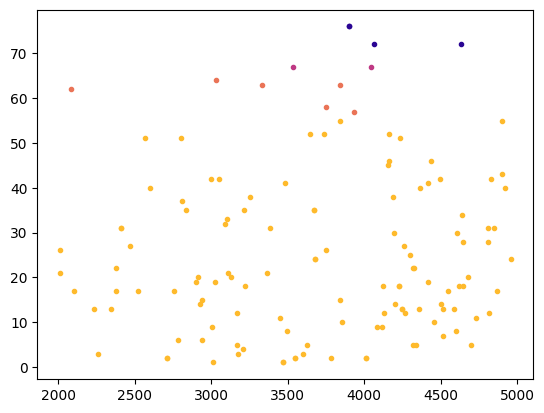

In [13]:
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_yso)

N_cand:  88
N_cont within 200-5000 (before correction):  40.26
N_cont within 200-5000:  25.621832851133142
N_contaminants:  854.0
N_comp:  62.37816714886685
CF (671):  0.13114754098360656


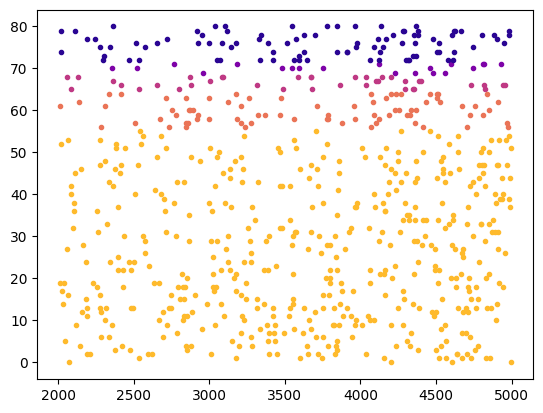

In [118]:
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_yso)#plots dm*10 vs sep

N_cand:  93
N_cont within 200-5000 (before correction):  40.26
N_cont within 200-5000:  32.97665921720069
N_contaminants:  854.0
N_comp:  87.48445267696059
CF (671):  0.13037921412363723


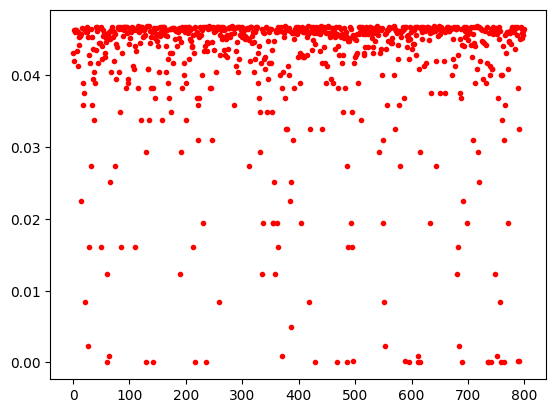

In [78]:
dmag, R, dist = CF(ra_f2, dec_f2, m_f2, i_yso) ##plots R

In [79]:
854*0.047

40.138

In [ ]:
plt.subplot()
plt.plot(dmag, R/(1000**2-100**2)*(5000**2-2000**2), '.r')

--------------


## Testing calculations with Guided Survey

In [14]:
guided =  Table.read('wfc3.txt', format='ascii')

In [15]:
catalog = guided[guided['wfc3m']!=-0.0]
catalog

ra,dec,wfc3m,wfc3u,nic1.6m,nic1.6u,nic2.05m,nic2.05u,irtfm,irtfu,hops,separation,closesthops,4thnearest
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
88.737286,1.7155785,13.502162,0.041815419,0.0,0.0,0.0,0.0,10.042865,0.0069383709,3.0,0.0,3.0,226262.17
83.867269,-5.1705367,10.153605,0.047382092,0.0,0.0,0.0,0.0,8.5100002,0.0099999998,-1041.0,0.0,-1041.0,11024.07
83.867387,-5.1700753,13.109348,0.048968194,0.0,0.0,0.0,0.0,11.7,0.1,0.0,720.02943,-1041.0,0.0
83.856884,-5.1325495,10.777232,0.027959219,10.489038,0.001,10.214037,0.001,10.07,0.1,0.0,450.22175,71.0,0.0
83.856605,-5.1326541,18.24376,0.23583913,20.456038,0.0020000001,14.572037,0.0020000001,10.2,0.2,71.0,0.0,71.0,16048.257
83.856402,-5.1324409,12.709577,0.029863019,12.474038,0.0020000001,12.162037,0.0020000001,11.35,0.0033656652,0.0,445.27254,71.0,0.0
83.843163,-5.1275248,12.262151,0.030911366,0.0,0.0,0.0,0.0,8.3172455,0.003998179,-1053.0,0.0,-1053.0,18873.717
84.680734,-7.0263693,12.645921,0.033995372,0.0,0.0,0.0,0.0,10.0,0.1,0.0,302.028,-1131.0,0.0
84.680539,-7.0263264,13.060127,0.034622159,0.0,0.0,0.0,0.0,9.4700003,0.2,-1131.0,0.0,-1131.0,18026.508


In [127]:
#Pre-MS hops<0
#Protostar hops>0
#
c_prems = catalog[(catalog['hops']<0)]
c_proto = catalog[(catalog['hops']>0)]
c_protocand = catalog[(catalog['separation']<1000.)|(catalog['separation']>100.)&(catalog['closesthops']>0.)
        &(catalog['hops']==0.)]
c_premscand = catalog[(catalog['hops']==0)&(catalog['separation']<1000)&(catalog['separation']>100)&(catalog['closesthops']<0.)]

c_yso = vstack([c_prems, c_proto, c_protocand, c_premscand])


In [42]:
len(c_protocand), len(catalog), len(c_proto), len(c_prems)

(20, 4984, 129, 197)

In [135]:
i_prems, = np.where(catalog['hops']<0)
i_proto, = np.where((catalog['hops']>0)|((catalog['separation']<1000.)&(catalog['separation']>100.)&(catalog['closesthops']>0.)
        &(catalog['hops']==0.)))
i_Gyso,  = np.where(((catalog['hops']==0)&(catalog['separation']<1000)&(catalog['separation']>100)&
         (catalog['closesthops']<0.))|(catalog['hops']<0)|(catalog['hops']>0))

In [137]:
catalog[np.isin((catalog['hops']>0),((catalog['separation']<1000.)&(catalog['separation']>100.)&(catalog['closesthops']>0.)
        &(catalog['hops']==0.)))]

ra,dec,wfc3m,wfc3u,nic1.6m,nic1.6u,nic2.05m,nic2.05u,irtfm,irtfu,hops,separation,closesthops,4thnearest
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
88.737286,1.7155785,13.502162,0.041815419,0.0,0.0,0.0,0.0,10.042865,0.0069383709,3.0,0.0,3.0,226262.17
83.867269,-5.1705367,10.153605,0.047382092,0.0,0.0,0.0,0.0,8.5100002,0.0099999998,-1041.0,0.0,-1041.0,11024.07
83.867387,-5.1700753,13.109348,0.048968194,0.0,0.0,0.0,0.0,11.7,0.1,0.0,720.02943,-1041.0,0.0
83.856884,-5.1325495,10.777232,0.027959219,10.489038,0.001,10.214037,0.001,10.07,0.1,0.0,450.22175,71.0,0.0
83.856605,-5.1326541,18.24376,0.23583913,20.456038,0.0020000001,14.572037,0.0020000001,10.2,0.2,71.0,0.0,71.0,16048.257
83.856402,-5.1324409,12.709577,0.029863019,12.474038,0.0020000001,12.162037,0.0020000001,11.35,0.0033656652,0.0,445.27254,71.0,0.0
83.843163,-5.1275248,12.262151,0.030911366,0.0,0.0,0.0,0.0,8.3172455,0.003998179,-1053.0,0.0,-1053.0,18873.717
84.680734,-7.0263693,12.645921,0.033995372,0.0,0.0,0.0,0.0,10.0,0.1,0.0,302.028,-1131.0,0.0
84.680539,-7.0263264,13.060127,0.034622159,0.0,0.0,0.0,0.0,9.4700003,0.2,-1131.0,0.0,-1131.0,18026.508


In [132]:
ra_G  = catalog['ra']
dec_G = catalog['dec']
m_G   = catalog['wfc3m']

N_cand:  28
N_cont within 200-5000 (before correction):  8.532857142857143
N_cont within 200-5000:  4.660747634042242
N_contaminants:  181.0
N_comp:  23.339252365957762
CF (197):  0.14213197969543148


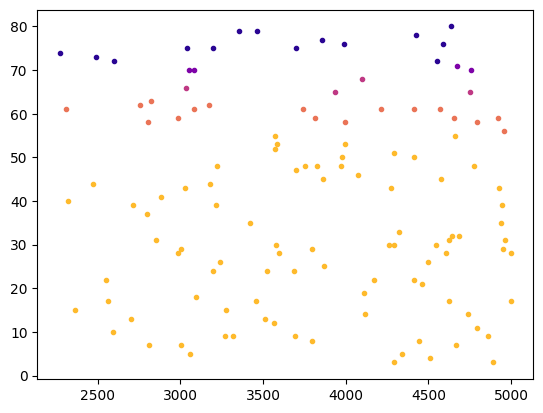

In [122]:
deltam, R, separations = CF(ra_G, dec_G, m_G, i_prems)

N_cand:  16
N_cont within 200-5000 (before correction):  6.081428571428571
N_cont within 200-5000:  4.01908996435181
N_contaminants:  129.0
N_comp:  11.98091003564819
CF (149):  0.10738255033557047


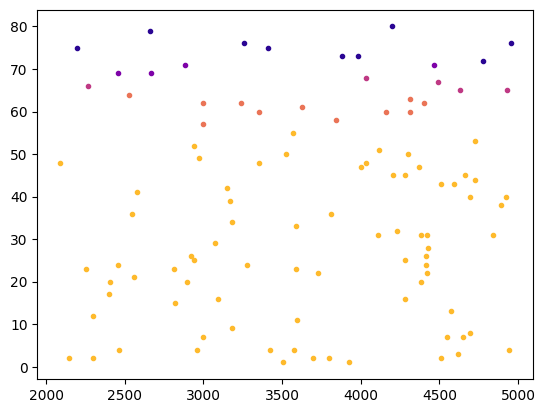

In [136]:
deltam, R, separations = CF(ra_G, dec_G, m_G, i_proto)

N_cand:  0
N_cont within 200-5000 (before correction):  0.0
N_cont within 200-5000:  0.0
N_contaminants:  0.0
N_comp:  0


ZeroDivisionError: division by zero

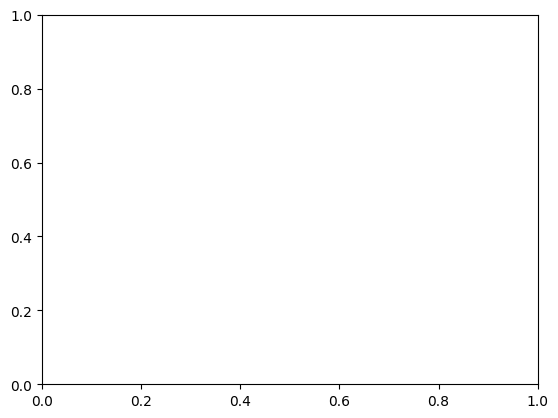

In [126]:
CF_G(ra_G, dec_G, m_G, i_proto)